In [1]:
import pandas as pd
import torch
from torch import nn
torch.set_float32_matmul_precision("high")

data = pd.read_csv("ETDataset/ETT-small/ETTm1.csv")
data["date"] = pd.to_datetime(data["date"])
data = data.drop(columns=["date"])
data -=data.mean()
data /=data.std()

In [2]:
from torch.utils.data import Dataset


class TimeDataset(Dataset):
    def __init__(self, data, pred_len, lookback_len):
        self.data = data
        self.pred_len = pred_len
        self.lookback_len = lookback_len

    def __getitem__(self, index):
        lookback = self.data[index: index + self.lookback_len]
        target = self.data[index + self.lookback_len: index + self.lookback_len + self.pred_len]
        return torch.tensor(lookback.values).float().detach(), torch.tensor(target.values).float().detach()

    def __len__(self):
        return self.data.shape[0] - self.pred_len - self.lookback_len

In [3]:
# SPLITS
lookback_len = 336
pred_len = 192
dataset = TimeDataset(data[:12 * 30 * 24], pred_len, lookback_len)
testset = TimeDataset(data[ 12 * 30 * 24 + 4 * 30 * 24 -lookback_len: 12 * 30 * 24 + 8 * 30 * 24], pred_len, lookback_len)

In [4]:
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from model import EfficaNet
from torch.optim import Adam
from torch.utils.data import DataLoader

BATCH_SIZE = 256

loader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True,
                    num_workers=8, shuffle=True, persistent_workers=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True, persistent_workers=True)

model = EfficaNet(embedding_dim=64, var_dim=7, size=lookback_len, output_dim=(pred_len, data.shape[1]), blocks=3).cuda()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.95)
def loss_fn(output, target):  #SMAPE
   return (2 * (output - target).abs() / (output.abs() + target.abs() + 1e-8)).mean()

#loss_fn = nn.MSELoss()
eval_fn = nn.L1Loss()
for epoch in range(100):
    model.train()
    epoch_loss = 0
    count = 0
    for lookback, target in tqdm(loader):
        optimizer.zero_grad()
        output = model(lookback.cuda())
        loss = loss_fn(output, target.cuda())
        epoch_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        count += 1
    scheduler.step()
    with torch.no_grad():
        model.eval()
        eval_loss = 0
        count_eval = 0
        for lookback, target in test_loader:
            lookback = lookback.cuda()
            target = target.cuda()
            output = model(lookback)
            loss = eval_fn(output, target)
            eval_loss += loss.item()
            count_eval += 1
    print(f"Epoch {epoch} loss: {epoch_loss / count} Eval loss: {eval_loss / count_eval}")
    print(scheduler.get_last_lr())

100%|██████████| 31/31 [00:01<00:00, 15.55it/s]


Epoch 0 loss: 0.6869723008524987 Eval loss: 0.43695007264614105
[9.5e-05]


100%|██████████| 31/31 [00:01<00:00, 18.31it/s]


Epoch 1 loss: 0.6434501986349782 Eval loss: 0.4137719929218292
[9.025e-05]


100%|██████████| 31/31 [00:01<00:00, 18.34it/s]


Epoch 2 loss: 0.6220605354155263 Eval loss: 0.40413835644721985
[8.573749999999999e-05]


100%|██████████| 31/31 [00:01<00:00, 18.42it/s]


Epoch 3 loss: 0.6110156986021227 Eval loss: 0.397387170791626
[8.145062499999998e-05]


100%|██████████| 31/31 [00:01<00:00, 18.20it/s]


Epoch 4 loss: 0.6027588363616697 Eval loss: 0.391350531578064
[7.737809374999998e-05]


 58%|█████▊    | 18/31 [00:01<00:00, 17.83it/s]


KeyboardInterrupt: 

In [7]:
sum([i.numel() for i in model.parameters()])

18001862

/tmp/ipykernel_5832/1808394136.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(model(torch.tensor(testset[i][0]).unsqueeze(0).cuda()).squeeze(0)[:, v].cpu().detach().numpy())


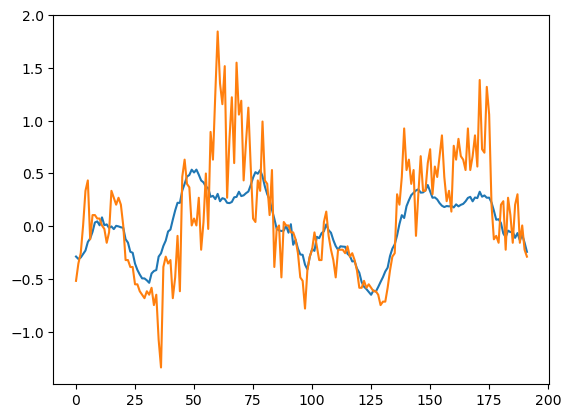

In [5]:
import matplotlib.pyplot as plt
i = 1200
v = 1
plt.plot(model(torch.tensor(testset[i][0]).unsqueeze(0).cuda()).squeeze(0)[:, v].cpu().detach().numpy())
plt.plot(testset[i][1][:, v])